### Tf-idf를 사용한 분류기

In [60]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드
data = pd.read_csv("news_data_ML.csv")

def clean_title(text):
    """ 뉴스 제목에서 불필요한 패턴과 문자를 제거합니다. """
    text = re.sub(r'\[.*?\]', '', text)  # 대괄호 안의 텍스트 제거
    text = re.sub(r'[\'"“”‘’]', '', text)  # 모든 종류의 따옴표(일반, 특수) 제거
    return text.strip()  # 양쪽 공백 제거

data['cleaned_title'] = data['title'].apply(clean_title)
# 모델 학습, 예측, 평가 등의 과정에 'encoded_category' 사용
# 예: true_labels = data['encoded_category']

# 데이터 전처리 
data['tokenized_text'] = data['cleaned_title'].apply(word_tokenize)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_title'], data['category'], test_size=0.3)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 나이브 베이즈 모델 초기화 및 훈련
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 모델 평가
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       IT/과학       0.00      0.00      0.00         6
          경제       1.00      0.03      0.06        30
          사회       0.69      0.97      0.80       180
       생활/문화       0.00      0.00      0.00        15
          정치       0.79      0.49      0.61        61

    accuracy                           0.70       292
   macro avg       0.50      0.30      0.29       292
weighted avg       0.69      0.70      0.63       292



C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### example_text에 원하는 제목을 입력해 예측 결과 확인

In [41]:
example_text = "EU, 반도체·AI 등 민감기술 투자·수출 통제 추진"

# 전체 텍스트에 대한 벡터 변환
example_text_vec = vectorizer.transform([example_text])  # 리스트로 감싸서 전달

# 예측 수행
predicted_category = model.predict(example_text_vec)

print(f"제목: {example_text} \n예측된 카테고리: {predicted_category[0]}")

제목: EU, 반도체·AI 등 민감기술 투자·수출 통제 추진 
예측된 카테고리: 사회


Multinomial Naive Bayes 모델은 각 클래스에 대한 각 단어의 로그 조건부 확률을 feature_log_prob_ 속성에 저장한다.  
이 값을 사용하여 각 클래스에 대한 가장 중요한 단어들을 확인해보자.

In [61]:
import numpy as np

# TF-IDF 벡터라이저의 특성 이름 가져오기
feature_names = vectorizer.get_feature_names_out()

# 각 클래스에 대한 상위 N개 중요 단어를 추출하는 함수
def top_n_words_per_class(class_index, n=10):
    sorted_indices = model.feature_log_prob_[class_index, :].argsort()[::-1]
    top_n = feature_names[sorted_indices][:n]
    return top_n

# 각 클래스에 대한 상위 단어들 출력
for i in range(len(model.classes_)):
    class_name = model.classes_[i]
    top_words = top_n_words_per_class(i, 10)
    print(f"Class: {class_name}")
    print(f"Top words: {', '.join(top_words)}\n")


Class: IT/과학
Top words: 개통, 사전, 갤럭시, skt, 시리즈, s24, 갤럭시s24, 뉴스혁신포럼, 출범, 투명성

Class: 경제
Top words: 플랫폼법, 공정위, 역차별은, 역대, gtx, lpg, 충전소, 안덕근, 거짓뉴스, 최고

Class: 사회
Top words: 1월, 26일, 25일, 새로운미래, 이낙연, 무죄, 양승태, 배현진, 뉴스, 클로징

Class: 생활/문화
Top words: 유인촌, 장관, 문체부, 강릉, 바우길, 찾은, 추위, 함께하는, 시청자와, 프로그램

Class: 정치
Top words: 30, 한동훈, 배현진, 대통령, 10, 00, 18, 31, 피습, 쌍특검법



In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

def clean_title(text):
    """ 뉴스 제목에서 불필요한 패턴과 문자를 제거합니다. """
    text = re.sub(r'\[.*?\]', '', text)  # 대괄호 안의 텍스트 제거
    text = re.sub(r'[\'"“”‘’]', '', text)  # 모든 종류의 따옴표(일반, 특수) 제거
    return text.strip()  # 양쪽 공백 제거

data['cleaned_title'] = data['title'].apply(clean_title)

# 파이프라인 생성: TF-IDF 벡터화 및 나이브 베이즈 모델
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 교차 검증 수행
cross_val_scores = cross_val_score(pipeline, data['cleaned_title'], data['category'], cv=10, scoring='accuracy')

# 교차 검증 결과 출력
print("교차 검증 정확도 점수:", cross_val_scores)
print("평균 정확도:", np.mean(cross_val_scores))


교차 검증 정확도 점수: [0.68367347 0.67346939 0.75510204 0.72164948 0.74226804 0.71134021
 0.69072165 0.67010309 0.70103093 0.65979381]
평균 정확도: 0.7009152114454029


In [79]:
from sklearn.model_selection import GridSearchCV

# TF-IDF 벡터화 및 나이브 베이즈 모델 파이프라인
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# 하이퍼파라미터 그리드 설정
param_grid = {
    'multinomialnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]  # MultinomialNB의 alpha 값 범위
}

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
# 데이터 전처리 및 문서 벡터 변환 코드 (생략)

# 하이퍼파라미터 튜닝 실행
random_search.fit(data['cleaned_title'], data['category'])

# 최적의 파라미터와 점수 출력
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


C:\Users\endnj\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'multinomialnb__alpha': 0.1}
Best Score: 0.7625799629923341


### Word2Vec를 사용한 분류기

In [66]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

def clean_title(text):
    """ 뉴스 제목에서 불필요한 패턴과 문자를 제거합니다. """
    text = re.sub(r'\[.*?\]', '', text)  # 대괄호 안의 텍스트 제거
    text = re.sub(r'[\'"“”‘’]', '', text)  # 모든 종류의 따옴표(일반, 특수) 제거
    return text.strip()  # 양쪽 공백 제거

data['cleaned_title'] = data['title'].apply(clean_title)


data['tokenized_text'] = data['title'].apply(word_tokenize)
# Word2Vec 모델 훈련
w2v_model = Word2Vec(data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# 문서별 평균 벡터 계산 함수
def document_vector(doc):
    # 단어 벡터의 평균을 계산
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0)

# 각 문서에 대한 문서 벡터 생성
data['doc_vector'] = data['tokenized_text'].apply(document_vector)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data['doc_vector'].tolist(), data['category'], test_size=0.3)

# 분류기 훈련
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

# 예측을 위한 함수 정의
def predict_category(text, w2v_model, classifier):
    # 텍스트를 토큰화하고 Word2Vec 모델을 사용하여 벡터 생성
    tokenized_text = text.split()
    doc_vector = document_vector(tokenized_text)
    if np.isnan(doc_vector).any():
        doc_vector = np.zeros(w2v_model.vector_size)
    
    # 예측 수행
    predicted_category = classifier.predict([doc_vector])
    return predicted_category[0]

# 모델 평가
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       1.00      0.25      0.40         4
          경제       1.00      0.09      0.17        32
          사회       0.64      0.99      0.78       169
       생활/문화       1.00      0.25      0.40         8
          정치       0.89      0.30      0.45        79

    accuracy                           0.67       292
   macro avg       0.91      0.38      0.44       292
weighted avg       0.76      0.67      0.61       292



Word2Vec 모델은 훈련 데이터에 있는 단어들만 학습한다. 만약 예측하려는 텍스트에 훈련 데이터에 없는 새로운 단어가 포함되어 있다면, 이 단어들은 Word2Vec 모델에 의해 벡터로 변환되지 않기 때문에, 제대로 예측하지 못하거나 에러가 나온다.
즉 뉴스 제목으로 카테고리를 예측하는 모델을 만들 때 Word2Vec 모델을 사용한다면, 뉴스 제목에 어떤 단어가 들어와도 그 단어가 훈련 데이터 안에 있어야 하도록 어마어마한 양의 훈련 데이터가 필요하다는 뜻이다.

In [39]:
#제목에 있는 단어가 학습 데이터에 모두 있는 경우
example_text_1 = "“유튜브만 믿어!”…극혐 정치·가짜뉴스 키우는 SNS"
predicted_category_1 = predict_category(example_text_1, w2v_model, classifier)
print(f"제목: {example_text_1} \n예측된 카테고리: {predicted_category_1}")

# #제목에 학습 데이터에 없는 단어가 있는 경우 - ValueError: need at least one array to concatenate
# example_text_2 = "한국원자력학회, 고준위 방폐물 특별법 처리 촉구"
# predicted_category_2 = predict_category(example_text_2, w2v_model, classifier)
# print(f"제목: {example_text_2} \n예측된 카테고리: {predicted_category_2}")

제목: “유튜브만 믿어!”…극혐 정치·가짜뉴스 키우는 SNS 
예측된 카테고리: 사회


Word2Vec에서 각 특성은 Word2Vec 모델에 의해 생성된 개별 차원(word -> vector)을 나타내기 때문에, 카테고리 결정에 영향을 미치는 구체적인 단어를 파악하고자 한다면 TF-IDF를 사용해야 한다.

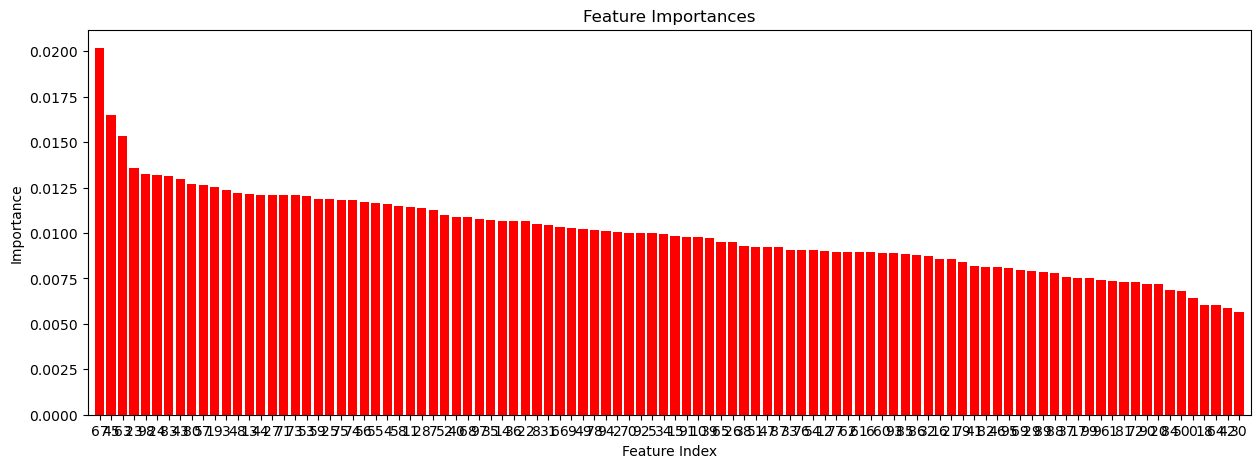

In [40]:
import matplotlib.pyplot as plt

# RandomForestClassifier의 feature importance 추출
importances = classifier.feature_importances_

# feature importance를 시각화
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.xlabel('Feature Index') #xlabel 이 단어가 아닌 벡터로 나온다.
plt.ylabel('Importance')
plt.show()

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

#전체 문서 벡터를 NumPy 배열로 변환
X = np.array(data['doc_vector'].tolist())
y = data['category']

# RandomForestClassifier 초기화
classifier = RandomForestClassifier()

# 교차 검증 실행 (예: 5-폴드 교차 검증)
scores = cross_val_score(classifier, X, y, cv=10)

# 평균 정확도 출력
print("교차 검증 정확도:", scores)
print("평균 정확도:", np.mean(scores))

교차 검증 정확도: [0.675      0.575      0.6375     0.6375     0.6375     0.59493671
 0.60759494 0.62025316 0.62025316 0.63291139]
평균 정확도: 0.6238449367088607


위처럼 교차검증을 하려했는데,   
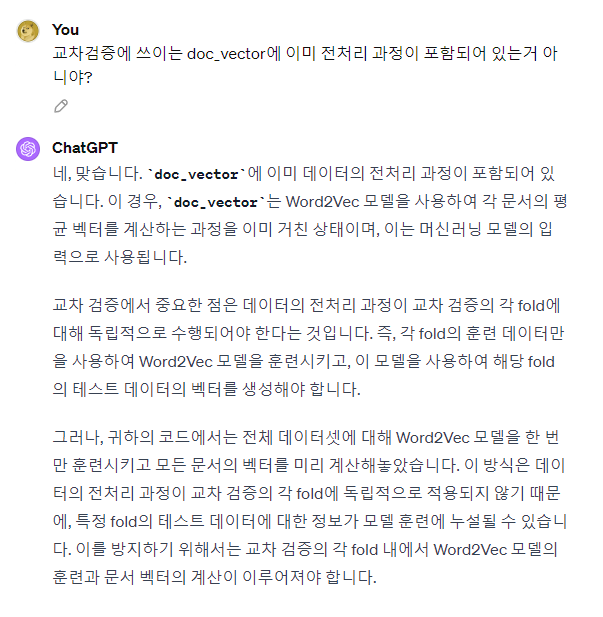   
gpt에서 생각치 못했던 허점을 잡아줬다. doc_vector에 전처리 과정이 들어간건 맞지만, 데이터의 전처리 과정이 교차 검증의 각 fold에 대해 독립적으로 수행되어야 하기에, 위 처럼 코드를 짜면 제대로된 검증이 되지 않는다는 뜻이었다. 따라서 교차검증도 처음 모델을 만들 때 처럼 전처리 과정을 포함시켜서 진행하였다.

In [58]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

def clean_title(text):
    # 뉴스 제목에서 불필요한 패턴과 문자를 제거하는 함수
    text = re.sub(r'\[.*?\]|\(.*?\)|[\'"“”‘’]', '', text)
    return text.strip()

data['cleaned_title'] = data['title'].apply(clean_title)
data['tokenized_text'] = data['cleaned_title'].apply(word_tokenize)

# K-Fold 교차 검증 설정
kf = KFold(n_splits=10, shuffle=True, random_state=24)
accuracies = []

for train_index, test_index in kf.split(data):
    # 훈련 데이터와 테스트 데이터 분할
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy()

    # Word2Vec 모델 훈련
    w2v_model = Word2Vec(train_data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

    # 문서별 평균 벡터 계산 함수
    def document_vector(doc):
        doc = [word for word in doc if word in w2v_model.wv.index_to_key]
        return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(100)

    # 각 문서에 대한 문서 벡터 생성
    train_data['doc_vector'] = train_data['tokenized_text'].apply(document_vector)
    test_data['doc_vector'] = test_data['tokenized_text'].apply(document_vector)

    # 분류기 훈련 및 예측
    classifier = RandomForestClassifier()
    classifier.fit(list(train_data['doc_vector']), train_data['category'])

    predictions = classifier.predict(list(test_data['doc_vector']))
    accuracy = accuracy_score(test_data['category'], predictions)
    accuracies.append(accuracy)

# 평균 정확도 출력
print("교차 검증 정확도:", accuracies)
print("평균 정확도:", np.mean(accuracies))


교차 검증 정확도: [0.7857142857142857, 0.6938775510204082, 0.673469387755102, 0.7319587628865979, 0.711340206185567, 0.7628865979381443, 0.6597938144329897, 0.6494845360824743, 0.6804123711340206, 0.6804123711340206]
평균 정확도: 0.7029349884283611


In [68]:
import numpy as np
import pandas as pd
import nltk
import warnings
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#iloc 대신 loc 사용하라는 경고창 제거(loc 사용시 DataFrame의 크기가 큰 경우 성능 저하가 발생)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# 데이터 로드 및 전처리
data = pd.read_csv("news_data_ML.csv")

def clean_title(text):
    # 뉴스 제목에서 불필요한 패턴과 문자를 제거하는 함수
    text = re.sub(r'\[.*?\]|\(.*?\)|[\'"“”‘’]', '', text)
    return text.strip()

data['cleaned_title'] = data['title'].apply(clean_title)
data['tokenized_text'] = data['cleaned_title'].apply(word_tokenize)

# 전체 데이터셋에 대해 Word2Vec 모델 훈련
w2v_model = Word2Vec(data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

def document_vector(doc, w2v_model):
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(w2v_model.vector_size)

# K-Fold 교차 검증 설정
kf = KFold(n_splits=10, shuffle=True, random_state=24)
accuracies = []

for train_index, test_index in kf.split(data):
    # 훈련 데이터와 테스트 데이터 분할
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # 각 문서에 대한 문서 벡터 생성
    train_data['doc_vector'] = train_data['tokenized_text'].apply(lambda doc: document_vector(doc, w2v_model))
    test_data['doc_vector'] = test_data['tokenized_text'].apply(lambda doc: document_vector(doc, w2v_model))

    # 분류기 훈련 및 예측
    classifier = RandomForestClassifier()
    classifier.fit(list(train_data['doc_vector']), train_data['category'])

    predictions = classifier.predict(list(test_data['doc_vector']))
    accuracy = accuracy_score(test_data['category'], predictions)
    accuracies.append(accuracy)

# 평균 정확도 출력
print("교차 검증 정확도:", accuracies)
print("평균 정확도:", np.mean(accuracies))


교차 검증 정확도: [0.7653061224489796, 0.7244897959183674, 0.6632653061224489, 0.7422680412371134, 0.7010309278350515, 0.7835051546391752, 0.6597938144329897, 0.6597938144329897, 0.6288659793814433, 0.6907216494845361]
평균 정확도: 0.7019040605933096


In [75]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# 문서 벡터 중 하나의 길이 확인
vector_length = len(data['doc_vector'].iloc[0])

# 하이퍼파라미터 범위 설정
param_dist = {
    "n_estimators": sp_randint(100, 1000),
    "max_depth": sp_randint(3, 20),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
    "max_features": sp_randint(1, vector_length)  # 수정된 부분
}

# 랜덤 포레스트 분류기 초기화
rf = RandomForestClassifier()

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=10, random_state=24)

# 데이터 전처리 및 문서 벡터 변환 코드 (생략)

# 하이퍼파라미터 튜닝 실행
random_search.fit(list(data['doc_vector']), data['category'])

# 최적의 파라미터와 점수 출력
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Parameters: {'max_depth': 15, 'max_features': 96, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 160}
Best Score: 0.6566694719124762
